In [3]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import time
import os

from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.asymmetric import rsa, ec, padding
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.primitives import padding as sym_padding

class SmartGridNode:
    def __init__(self, node_id, encryption_type='Niederreiter', shared_key=None):
        self.node_id = node_id
        self.encryption_type = encryption_type
        self.public_key, self.private_key = self.generate_keys(shared_key=shared_key)

    def generate_keys(self, shared_key=None):
        if self.encryption_type == 'RSA':
            private_key = rsa.generate_private_key(public_exponent=65537, key_size=2048)
            public_key = private_key.public_key()
        elif self.encryption_type == 'ECC':
            private_key = ec.generate_private_key(ec.SECP384R1())
            public_key = private_key.public_key()
        elif self.encryption_type == 'AES':
            if shared_key is not None:
                key = shared_key
            else:
                key = os.urandom(32)  # 256-bit AES key
            return key, key  # Symmetric key, public and private keys are the same
        else:  # Simulate Niederreiter
            public_key = f'PublicKey_{self.node_id}'
            private_key = f'PrivateKey_{self.node_id}'
        return public_key, private_key

    def encrypt_data(self, data, receiver_public_key):
        if self.encryption_type == 'RSA':
            ciphertext = receiver_public_key.encrypt(
                data.encode(),
                padding.OAEP(
                    mgf=padding.MGF1(algorithm=hashes.SHA256()),
                    algorithm=hashes.SHA256(),
                    label=None
                )
            )
            return ciphertext
        elif self.encryption_type == 'ECC':
            # Simplified ECC encryption; in practice, use ECIES or similar schemes
            shared_key = self.private_key.exchange(ec.ECDH(), receiver_public_key)
            aes_cipher = Cipher(algorithms.AES(shared_key[:32]), modes.CBC(b'\x00'*16))
            encryptor = aes_cipher.encryptor()
            # Apply PKCS7 padding
            padder = sym_padding.PKCS7(128).padder()
            padded_data = padder.update(data.encode()) + padder.finalize()
            ciphertext = encryptor.update(padded_data) + encryptor.finalize()
            return ciphertext
        elif self.encryption_type == 'AES':
            iv = os.urandom(16)
            aes_cipher = Cipher(algorithms.AES(self.private_key), modes.CBC(iv))
            encryptor = aes_cipher.encryptor()
            # Apply PKCS7 padding
            padder = sym_padding.PKCS7(128).padder()  # 128 bits = 16 bytes block size
            padded_data = padder.update(data.encode()) + padder.finalize()
            ciphertext = iv + encryptor.update(padded_data) + encryptor.finalize()
            return ciphertext
        else:  # Simulate Niederreiter
            encrypted_data = f'Encrypted({data})_with_{receiver_public_key}'
            return encrypted_data

    def decrypt_data(self, encrypted_data, sender_public_key=None):
        if self.encryption_type == 'RSA':
            plaintext = self.private_key.decrypt(
                encrypted_data,
                padding.OAEP(
                    mgf=padding.MGF1(algorithm=hashes.SHA256()),
                    algorithm=hashes.SHA256(),
                    label=None
                )
            )
            return plaintext.decode().strip()
        elif self.encryption_type == 'ECC':
            shared_key = self.private_key.exchange(ec.ECDH(), sender_public_key)
            aes_cipher = Cipher(algorithms.AES(shared_key[:32]), modes.CBC(b'\x00'*16))
            decryptor = aes_cipher.decryptor()
            padded_plaintext = decryptor.update(encrypted_data) + decryptor.finalize()
            # Remove PKCS7 padding
            unpadder = sym_padding.PKCS7(128).unpadder()
            plaintext = unpadder.update(padded_plaintext) + unpadder.finalize()
            return plaintext.decode().strip()
        elif self.encryption_type == 'AES':
            iv = encrypted_data[:16]
            ciphertext = encrypted_data[16:]
            aes_cipher = Cipher(algorithms.AES(self.private_key), modes.CBC(iv))
            decryptor = aes_cipher.decryptor()
            padded_plaintext = decryptor.update(ciphertext) + decryptor.finalize()
            # Remove PKCS7 padding
            unpadder = sym_padding.PKCS7(128).unpadder()
            plaintext = unpadder.update(padded_plaintext) + unpadder.finalize()
            return plaintext.decode()
        else:  # Simulate Niederreiter
            decrypted_data = encrypted_data.split('_with_')[0].replace('Encrypted(', '').replace(')', '')
            return decrypted_data

    def sign_data(self, data):
        if self.encryption_type == 'RSA':
            signature = self.private_key.sign(
                data.encode(),
                padding.PSS(
                    mgf=padding.MGF1(hashes.SHA256()),
                    salt_length=padding.PSS.MAX_LENGTH
                ),
                hashes.SHA256()
            )
            return signature
        elif self.encryption_type == 'ECC':
            signature = self.private_key.sign(
                data.encode(),
                ec.ECDSA(hashes.SHA256())
            )
            return signature
        else:
            signature = f'Signature_of_{data}_by_{self.node_id}'
            return signature

    def verify_signature(self, data, signature, sender_public_key, sender_id):
        if self.encryption_type == 'RSA':
            try:
                sender_public_key.verify(
                    signature,
                    data.encode(),
                    padding.PSS(
                        mgf=padding.MGF1(hashes.SHA256()),
                        salt_length=padding.PSS.MAX_LENGTH
                    ),
                    hashes.SHA256()
                )
                return True
            except Exception as e:
                print(f'RSA Authentication Failed: {e}')
                return False
        elif self.encryption_type == 'ECC':
            try:
                sender_public_key.verify(
                    signature,
                    data.encode(),
                    ec.ECDSA(hashes.SHA256())
                )
                return True
            except Exception as e:
                print(f'ECC Authentication Failed: {e}')
                return False
        else:
            expected_signature = f'Signature_of_{data}_by_{sender_id}'
            return signature == expected_signature

def create_nodes(encryption_type):
    nodes = {}
    if encryption_type == 'AES':
        shared_key = os.urandom(32)  # 256-bit AES key
        for i in range(1, 6):
            nodes[i] = SmartGridNode(i, encryption_type, shared_key=shared_key)
    else:
        for i in range(1, 6):
            nodes[i] = SmartGridNode(i, encryption_type)
    return nodes

def run_experiment(encryption_type, num_experiments=50):
    nodes = create_nodes(encryption_type)

    # Define performance metrics lists
    throughputs = []
    latencies = []
    computational_overheads = []

    for _ in range(num_experiments):
        sender = nodes[1]
        receiver = nodes[3]
        data = 'PowerData'

        # Record start time
        start_time = time.time()

        # Encrypt data
        encrypt_start = time.time()
        encrypted_data = sender.encrypt_data(data, receiver.public_key)
        encrypt_end = time.time()
        encrypt_time = encrypt_end - encrypt_start

        # Sign data
        sign_start = time.time()
        signature = sender.sign_data(data)
        sign_end = time.time()
        sign_time = sign_end - sign_start

        # Simulate transmission time
        transmit_start = time.time()
        time.sleep(np.random.uniform(0.005, 0.015))  # Random delay between 5ms and 15ms
        transmit_end = time.time()
        transmit_time = transmit_end - transmit_start

        # Decrypt data
        decrypt_start = time.time()
        decrypted_data = receiver.decrypt_data(encrypted_data, sender.public_key)
        decrypt_end = time.time()
        decrypt_time = decrypt_end - decrypt_start

        # Verify signature
        verify_start = time.time()
        is_valid = receiver.verify_signature(decrypted_data, signature, sender.public_key, sender.node_id)
        verify_end = time.time()
        verify_time = verify_end - verify_start

        # Record end time
        end_time = time.time()

        # Calculate performance metrics
        total_time = end_time - start_time
        latencies.append(total_time)
        throughputs.append(len(data) / total_time)
        computational_overheads.append(encrypt_time + decrypt_time + sign_time + verify_time)

        # Optional: Verify data correctness
        if not is_valid or decrypted_data != data:
            print(f'Experiment failed: data validation did not pass.')

    return latencies, throughputs, computational_overheads

# Run experiments
encryption_types = ['Niederreiter', 'RSA', 'ECC', 'AES']
results = {}

for enc_type in encryption_types:
    print(f'Now testing {enc_type} encryption...')
    latencies, throughputs, computational_overheads = run_experiment(enc_type)
    results[enc_type] = {
        'latencies': np.array(latencies),
        'throughputs': np.array(throughputs),
        'computational_overheads': np.array(computational_overheads)
    }

# Output results (optional)
for enc_type in encryption_types:
    print(f"\nResults for {enc_type} encryption:")
    print(f"Average Latency: {np.mean(results[enc_type]['latencies']):.6f} seconds")
    print(f"Average Throughput: {np.mean(results[enc_type]['throughputs']):.6f} bytes/second")
    print(f"Average Computational Overhead: {np.mean(results[enc_type]['computational_overheads']):.6f} seconds")

Now testing Niederreiter encryption...
Now testing RSA encryption...
Now testing ECC encryption...
Now testing AES encryption...

Results for Niederreiter encryption:
Average Latency: 0.012311 seconds
Average Throughput: 799.945179 bytes/second
Average Computational Overhead: 0.000014 seconds

Results for RSA encryption:
Average Latency: 0.015972 seconds
Average Throughput: 600.979791 bytes/second
Average Computational Overhead: 0.004284 seconds

Results for ECC encryption:
Average Latency: 0.020206 seconds
Average Throughput: 464.217901 bytes/second
Average Computational Overhead: 0.007056 seconds

Results for AES encryption:
Average Latency: 0.012703 seconds
Average Throughput: 772.049997 bytes/second
Average Computational Overhead: 0.000298 seconds


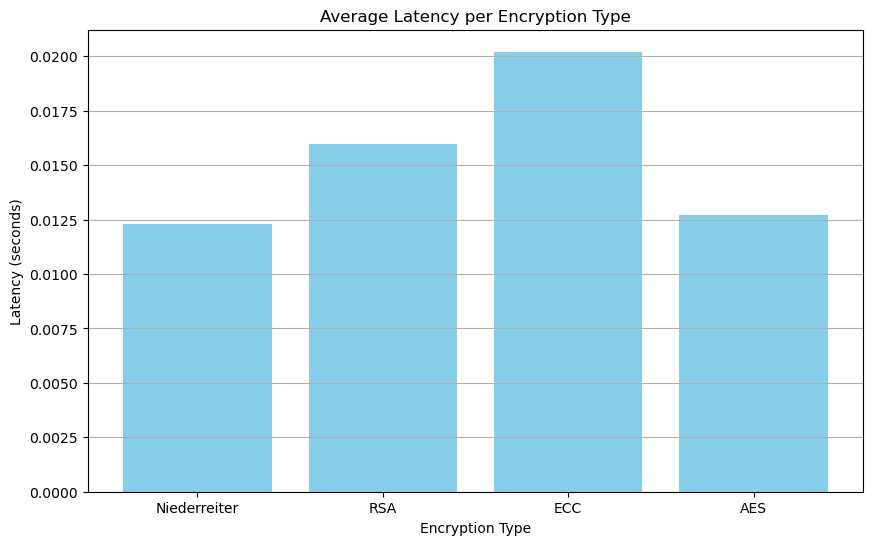

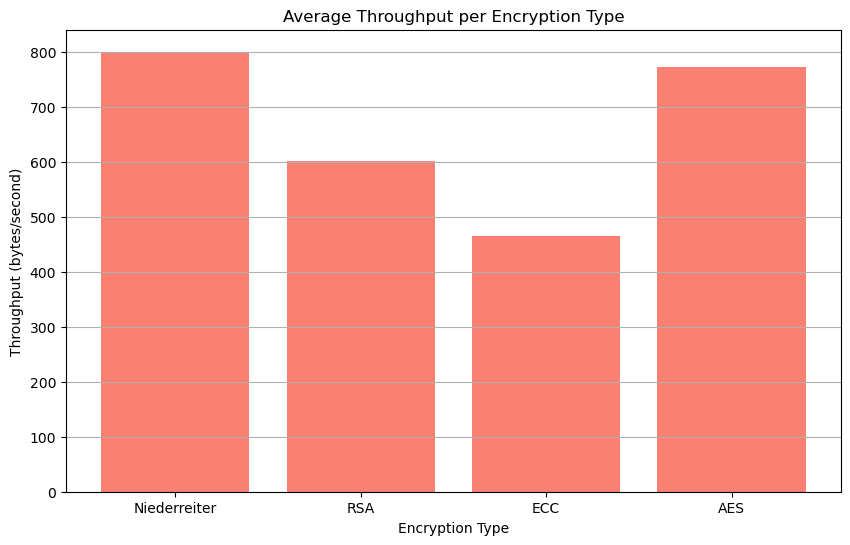

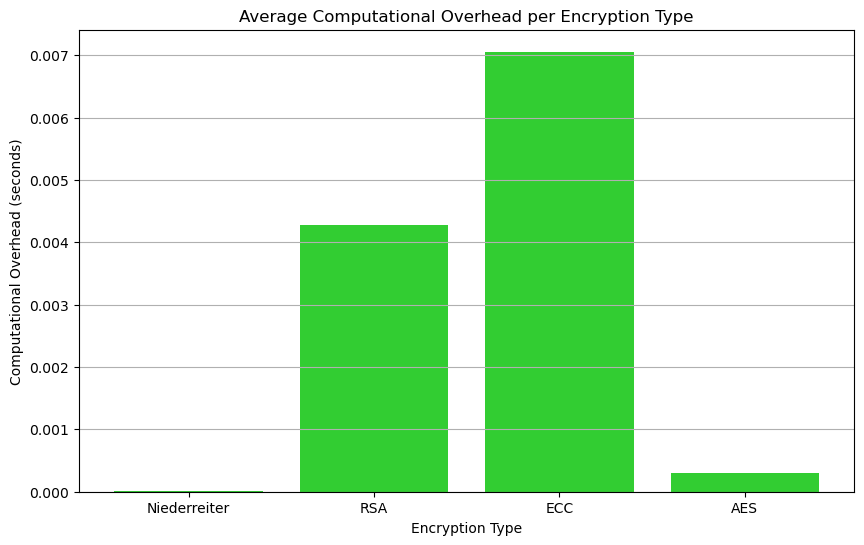

In [5]:
# Visualization
import matplotlib.pyplot as plt

# Calculate average metrics for each encryption type
average_latencies = []
average_throughputs = []
average_overheads = []

for enc_type in encryption_types:
    average_latencies.append(np.mean(results[enc_type]['latencies']))
    average_throughputs.append(np.mean(results[enc_type]['throughputs']))
    average_overheads.append(np.mean(results[enc_type]['computational_overheads']))

# Plot Average Latency
plt.figure(figsize=(10, 6))
plt.bar(encryption_types, average_latencies, color='skyblue')
plt.title('Average Latency per Encryption Type')
plt.ylabel('Latency (seconds)')
plt.xlabel('Encryption Type')
plt.grid(axis='y')
plt.show()

# Plot Average Throughput
plt.figure(figsize=(10, 6))
plt.bar(encryption_types, average_throughputs, color='salmon')
plt.title('Average Throughput per Encryption Type')
plt.ylabel('Throughput (bytes/second)')
plt.xlabel('Encryption Type')
plt.grid(axis='y')
plt.show()

# Plot Average Computational Overhead
plt.figure(figsize=(10, 6))
plt.bar(encryption_types, average_overheads, color='limegreen')
plt.title('Average Computational Overhead per Encryption Type')
plt.ylabel('Computational Overhead (seconds)')
plt.xlabel('Encryption Type')
plt.grid(axis='y')
plt.show()